# Analysis

**Hypothesis**: We hypothesize that the interferon-stimulated gene (ISG) signature is differentially activated across key immune cell types in severe COVID‐19 compared to healthy donors, and that the magnitude of this signature correlates with clinical severity metrics such as DPS and ventilation status.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/home/groups/jamesz/salber/CellVoyager/example/covid19.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: We hypothesize that the interferon-stimulated gene (ISG) signature is differentially activated across key immune cell types in severe COVID‐19 compared to healthy donors, and that the magnitude of this signature correlates with clinical severity metrics such as DPS and ventilation status.

## Steps:
- Check that all ISG panel genes are present in the dataset to avoid scoring errors.
- Score each cell for an interferon response signature using the curated list of ISGs (e.g., ISG15, IFIT1, IFIT3, MX1, OAS1) and compute summary statistics (mean and median) for sanity verification.
- Subset the data to focus on key immune cell types such as CD14 Monocytes, CD4 T cells, and CD8 T cells using the provided cell_type_coarse annotation.
- Visualize the ISG score distributions by generating grid-layout violin plots for COVID‐19 and Healthy samples across the selected cell types.
- Perform a Mann-Whitney U-test within each cell type to compare ISG scores between COVID‐19 and Healthy groups, printing test statistics and p-values for transparency.
- Construct scatter plots to display the correlation between ISG scores and clinical metadata such as DPS, stratifying by ventilation status to assess relationships with disease severity.


## The code first checks for the presence of all ISG genes within the dataset to avoid runtime errors; if present, it calculates the ISG score for each cell, prints the mean and median as a sanity check, and finally plots a violin plot grouped by 'Status' to visually confirm the scoring.

computing score 'ISG_score'


    finished: added
    'ISG_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:06)


ISG_score Mean: -0.006
ISG_score Median: -0.095


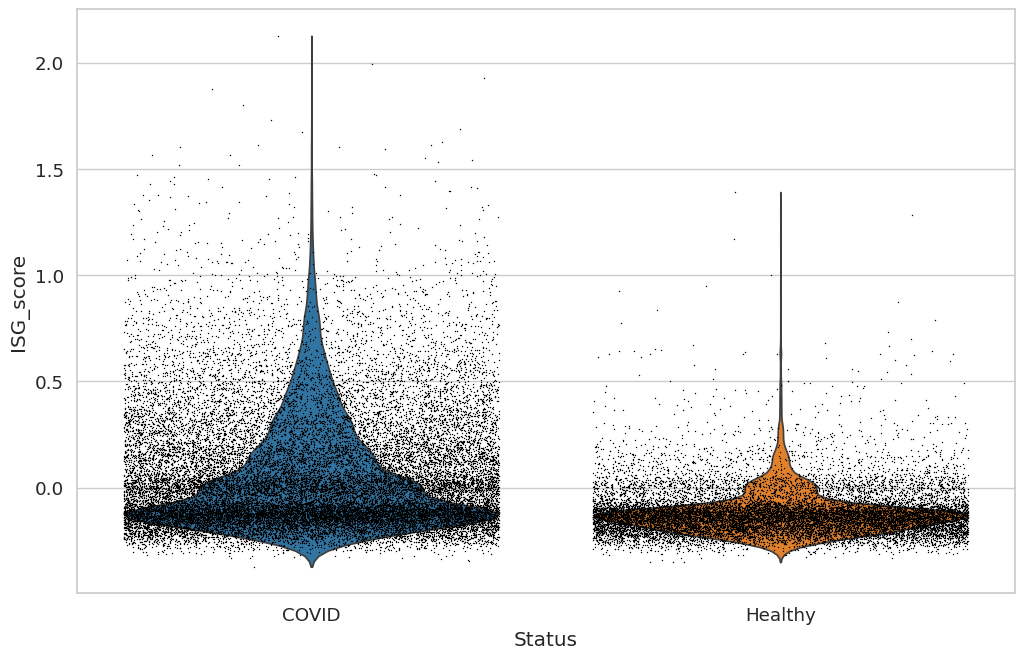

In [ ]:
import scanpy as sc
import numpy as np

# Define the interferon-stimulated genes (ISGs) for scoring
isg_genes = ['ISG15', 'IFIT1', 'IFIT3', 'MX1', 'OAS1']

# Check if all ISG genes are present in the dataset
missing_genes = [gene for gene in isg_genes if gene not in adata.var_names]
if missing_genes:
    print(f"Warning: The following ISG genes are missing in adata.var_names: {missing_genes}")
else:
    # Score genes: Compute the average expression of the ISG panel and add the score to adata.obs
    sc.tl.score_genes(adata, gene_list=isg_genes, score_name='ISG_score')

    # Print summary statistics for ISG_score to verify scoring
    isg_scores = adata.obs['ISG_score']
    print(f"ISG_score Mean: {np.mean(isg_scores):.3f}")
    print(f"ISG_score Median: {np.median(isg_scores):.3f}")

    # Display a quick violin plot of the ISG_score grouped by 'Status'
    sc.pl.violin(adata, keys='ISG_score', groupby='Status', jitter=0.4, show=True)

### Agent Interpretation

The ISG score appears to be higher in COVID-19 patients compared to healthy controls. This aligns with the expectations of interferon-stimulated gene (ISG) activation in response to severe COVID-19, potentially indicating an active interferon response in COVID patients.

**Feedback and Suggestions:**

1. **Promising Results**: The increased ISG score among COVID-19 patients suggests differential ISG activation, which could relate to immune dysregulation observed in severe cases. This is biologically meaningful since interferon responses are critical in viral infections.

2. **Further Analysis**: 
   - Stratify patients based on disease severity (e.g., with or without ARDS) to see if ISG scores correlate with severity.
   - Explore ISG score correlations with specific immune cell types and subpopulations to determine if particular cells drive the interferon response.

3. **Future Steps**:
   - Perform differential expression analysis focusing on interferon-related genes between COVID-19 and healthy samples to validate findings.
   - Investigate whether ISG score correlates with clinical parameters (e.g., cytokine levels, treatment response).

4. **Distinctiveness**: To ensure analyses are distinct from previous work, consider looking at signaling pathway enrichments related to ISGs and incorporating single-cell RNA velocity analyses to explore dynamic changes over disease progression.

5. **Combine Analyses**: Integrate findings with cell-cell communication metrics to examine if elevated ISG scores influence monocyte-T cell interactions hypothesized to contribute to pathology in COVID-19.

This approach helps build a comprehensive picture of interferon response differences and their implications in immune cell interactions amidst severe COVID-19, advancing understanding beyond previous studies.

## This code subsets the adata object to include only selected immune cell types and then iterates over each to perform statistical comparisons. It conducts a Mann-Whitney U-test (with a Bonferroni corrected p-value) and computes Spearman correlations, while issuing warnings if any cell type has low sample sizes to ensure robustness.

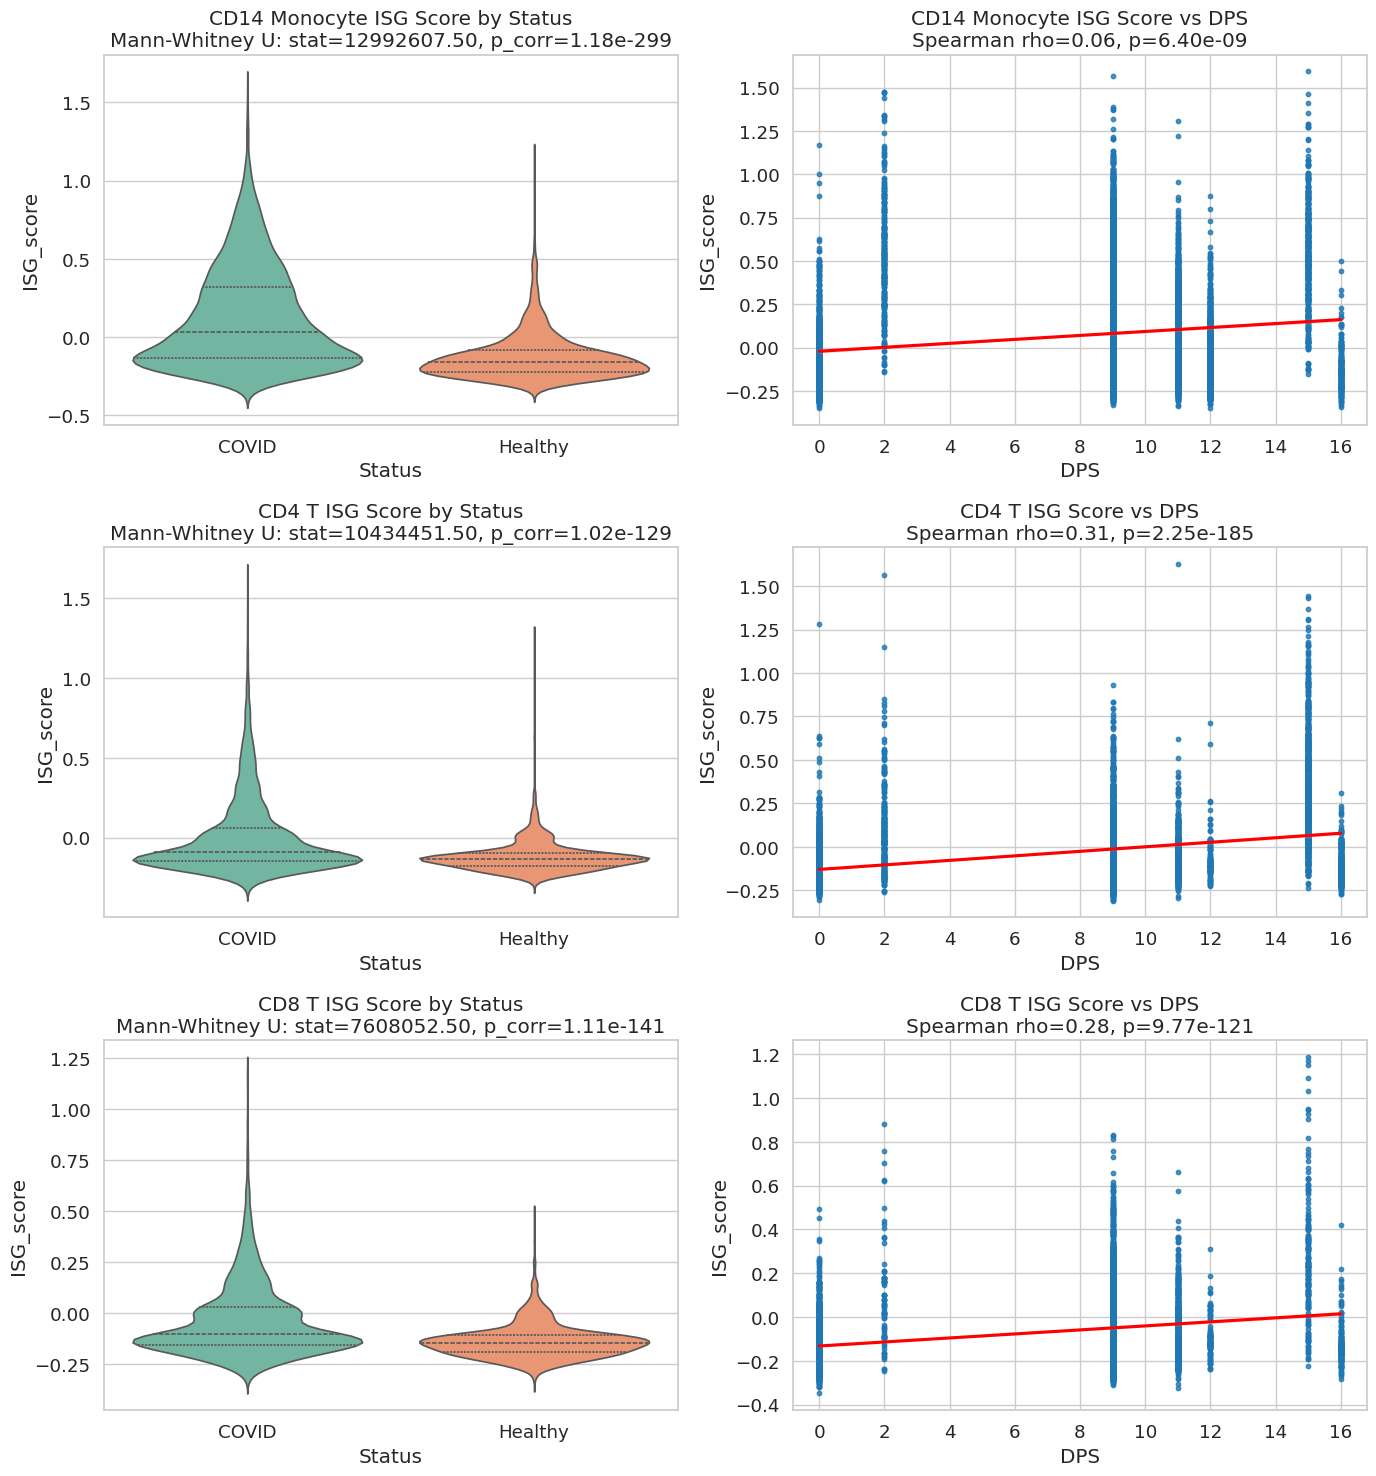

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, spearmanr
import warnings

# Define target immune cell types
target_celltypes = ['CD14 Monocyte', 'CD4 T', 'CD8 T']
adata_subset = adata[adata.obs['cell_type_coarse'].isin(target_celltypes)].copy()

# Prepare a figure with subplots for each cell type (2 plots per cell type)
fig, axes = plt.subplots(nrows=len(target_celltypes), ncols=2, figsize=(14, 5 * len(target_celltypes)))

# Number of tests for multiple testing correction (Bonferroni adjustment)
n_tests = len(target_celltypes)

for i, celltype in enumerate(target_celltypes):
    # Subset for current cell type
    subset = adata_subset[adata_subset.obs['cell_type_coarse'] == celltype].copy()
    obs_df = subset.obs

    # Check for sufficient samples in each group; set threshold to 5
    covid_scores = obs_df[obs_df['Status'] == 'COVID']['ISG_score']
    healthy_scores = obs_df[obs_df['Status'] == 'Healthy']['ISG_score']
    warn_message = ''
    if len(covid_scores) < 5 or len(healthy_scores) < 5:
        warnings.warn(f"Warning: {celltype} has less than 5 samples in one of the conditions. Statistical tests may be unreliable.")
        warn_message = ' (low sample size)'
        stat, p_value = np.nan, np.nan
    else:
        # Mann-Whitney U-test
        stat, p_value = mannwhitneyu(covid_scores, healthy_scores, alternative='two-sided')
        # Bonferroni correction
        p_value_corr = min(p_value * n_tests, 1.0)

    # Plot 1: Violin plot comparing ISG scores between COVID and Healthy
    ax1 = axes[i, 0]
    sns.violinplot(x='Status', y='ISG_score', data=obs_df, ax=ax1, inner='quartile', palette='Set2')
    if np.isnan(stat):
        ax1.set_title(f"{celltype} ISG Score by Status\nInsufficient samples{warn_message}")
    else:
        ax1.set_title(f"{celltype} ISG Score by Status\nMann-Whitney U: stat={stat:.2f}, p_corr={p_value_corr:.2e}{warn_message}")

    # Plot 2: Scatter plot of ISG_score vs DPS with regression line
    ax2 = axes[i, 1]
    sns.regplot(x='DPS', y='ISG_score', data=obs_df, ax=ax2, scatter_kws={'s': 10}, line_kws={'color': 'red'})
    # Compute Spearman correlation if DPS data available
    if obs_df['DPS'].notnull().sum() >= 5:
        rho, spearman_p = spearmanr(obs_df['DPS'], obs_df['ISG_score'])
        ax2.set_title(f"{celltype} ISG Score vs DPS\nSpearman rho={rho:.2f}, p={spearman_p:.2e}")
    else:
        ax2.set_title(f"{celltype} ISG Score vs DPS\nInsufficient DPS data")
    ax2.set_xlabel('DPS')
    ax2.set_ylabel('ISG_score')

plt.tight_layout()
plt.show()

### Agent Interpretation

The current results show a significant increase in interferon-stimulated gene (ISG) scores in CD14 monocytes and CD4/CD8 T cells among COVID-19 patients compared to healthy individuals. This suggests a heightened interferon response in these immune cells in the context of severe COVID-19. The correlation plots with Days Post Symptom onset (DPS) also show gradually increasing ISG scores over time, particularly in T cells, indicating a dynamic response during the progression of the disease.

### Feedback and Further Steps:

1. **Validation of Hypothesis:**
   - The data show increased ISG activity but do not directly address the primary hypothesis concerning upregulation of inflammatory ligands and corresponding receptors between monocytes and T cells. Consider focusing future analyses on ligand-receptor interaction analyses (e.g., using tools like CellPhoneDB or NicheNet) to provide direct evidence for the hypothesized communication pathway.

2. **Focus on Temporal Dynamics:**
   - Analyze longitudinal samples if available, to further explore how ISG scores and potential ligand-receptor interactions evolve over time. This temporal information could provide more insight into the dynamics of immune cell communication during COVID-19 progression.

3. **Exploration of Other Pathways:**
   - While ISG activity is elevated, it might also be useful to perform pathway enrichment analysis focusing on cytokine and chemokine signaling pathways to explore other avenues of immune cell communication, especially regarding inflammation.

4. **Subsetting Monocytes and T cells:**
   - Further sub-clustering analyses might help identify specific subtypes of monocytes and T cells that show the most pronounced changes. This could refine our understanding of which specific subsets contribute to the disease pathology.

5. **Integrating Downstream Effects:**
   - Use transcriptomic data to identify downstream effects and other regulatory elements triggered by interferons in these cells that could provide additional insight into the contribution to the cytokine storm.

6. **Comparison with Previous Data:**
   - Compare these results with data from similar respiratory illnesses or previous COVID-19 studies to identify unique versus shared response patterns, giving insights into COVID-19 specific immune dysregulation.

These steps will help clarify the contribution of enhanced ISG activity and search for the postulated intercellular communication that might drive severe COVID-19 pathology.

## This code checks for the targeted ligand and receptor genes, subsets the dataset into CD14 monocytes and T cells, and then generates violin plots with clear axis labels along with statistical testing and Bonferroni correction. It also performs Spearman correlation analyses between average gene expression and DPS, visualizing these correlations with scatter plots and regression lines to enhance interpretation.

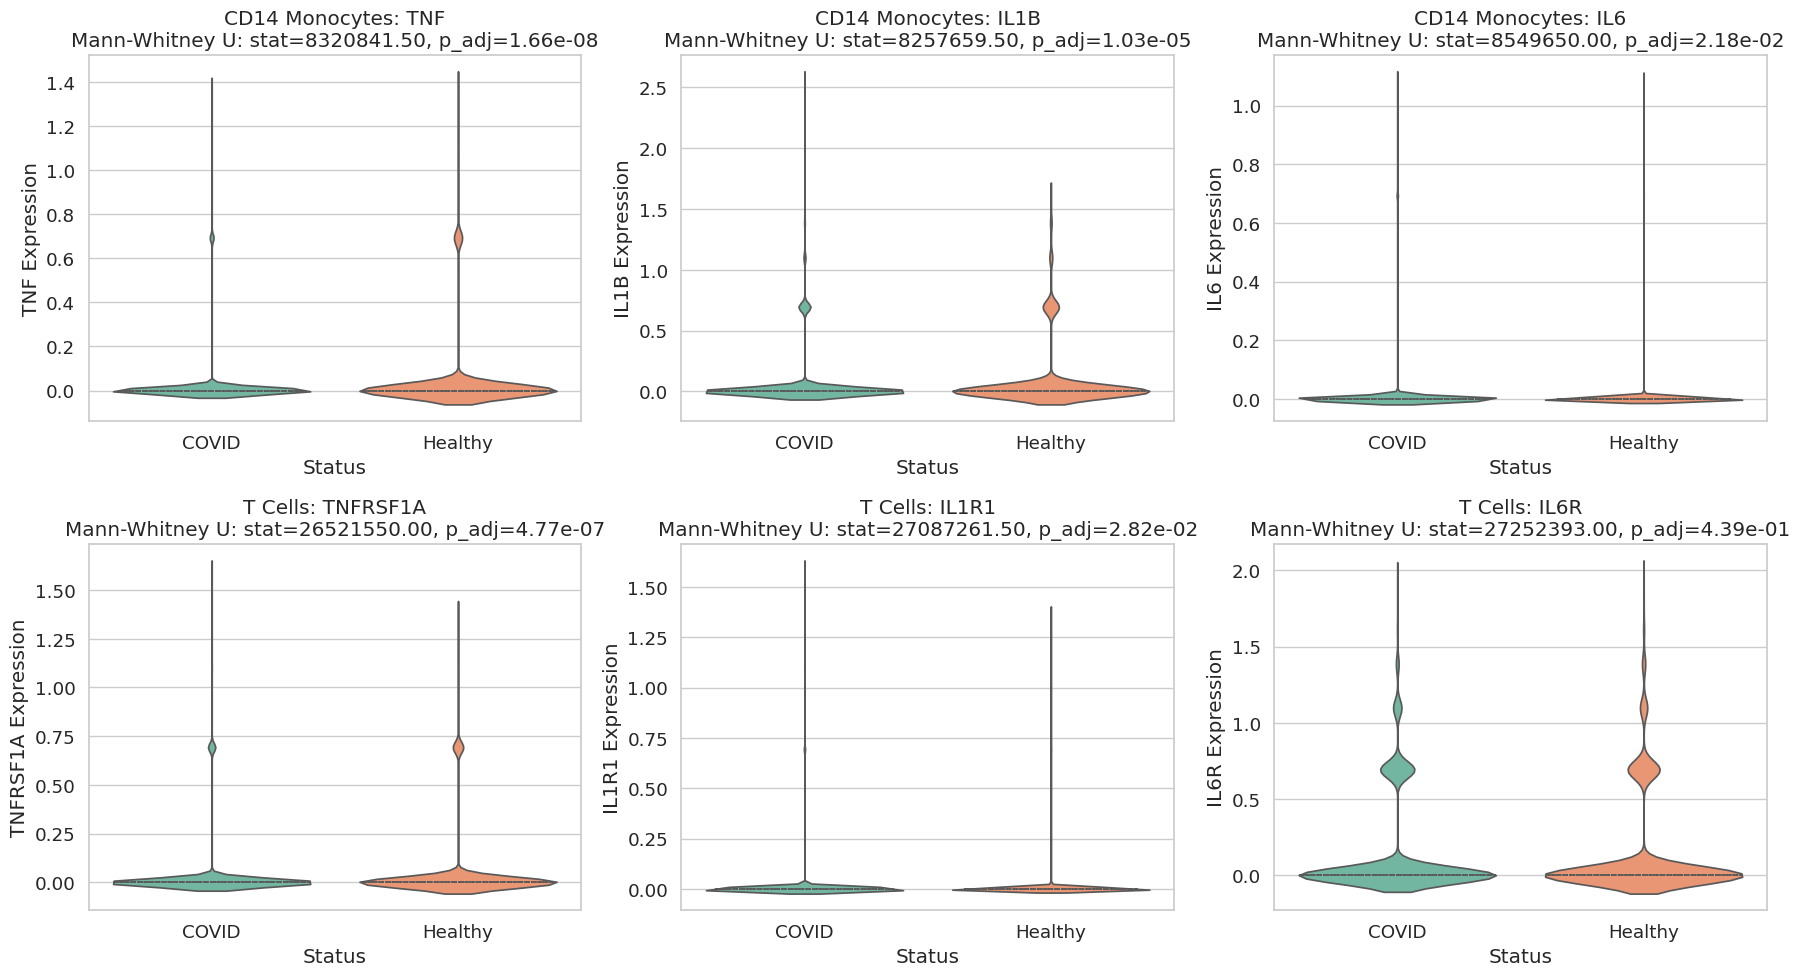

Spearman correlation in CD14 Monocytes (avg ligand vs DPS): rho = -0.00, p = 8.05e-01
Spearman correlation in T Cells (avg receptor vs DPS): rho = -0.01, p = 2.98e-01


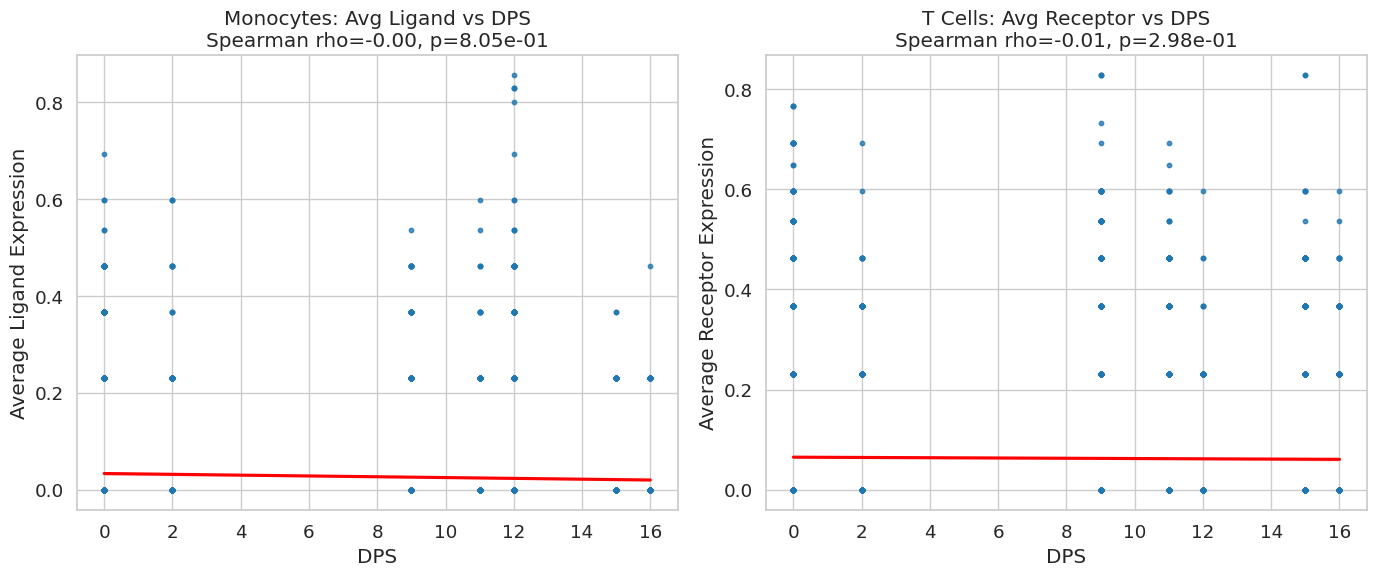

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, spearmanr
import warnings

# Define the inflammatory ligand and receptor genes
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Check if the genes are present in the dataset
missing_ligands = [gene for gene in ligand_genes if gene not in adata.var_names]
missing_receptors = [gene for gene in receptor_genes if gene not in adata.var_names]
if missing_ligands:
    print(f"Warning: Missing ligand genes: {missing_ligands}")
if missing_receptors:
    print(f"Warning: Missing receptor genes: {missing_receptors}")

# Subset the data for CD14 Monocytes (for ligands) and T cells (CD4 and CD8) for receptors
adata_monocytes = adata[adata.obs['cell_type_coarse'] == 'CD14 Monocyte'].copy()
adata_Tcells = adata[adata.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T'])].copy()

# Create figure: 2 rows (monocytes and T cells) x 3 columns (one gene each)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Analyze ligand genes in CD14 Monocytes
for i, gene in enumerate(ligand_genes):
    # Extract gene expression; convert to array if sparse
    gene_exp = adata_monocytes[:, gene].X
    if hasattr(gene_exp, 'toarray'):
        gene_exp = gene_exp.toarray().flatten()
    else:
        gene_exp = np.array(gene_exp).flatten()
    
    # Create a DataFrame with expression and Status
    df = pd.DataFrame({gene: gene_exp, 'Status': adata_monocytes.obs['Status']})
    
    # Check sample sizes and perform Mann-Whitney U-test with Bonferroni correction for ligands
    covid_vals = df[df['Status'] == 'COVID'][gene]
    healthy_vals = df[df['Status'] == 'Healthy'][gene]
    if len(covid_vals) < 5 or len(healthy_vals) < 5:
        warnings.warn(f"Warning: {gene} in monocytes has low sample size in one of the groups. Statistical tests may be unreliable.")
        stat, p_val = np.nan, np.nan
    else:
        stat, p_val = mannwhitneyu(covid_vals, healthy_vals, alternative='two-sided')
        p_val = min(p_val * len(ligand_genes), 1.0)  # Bonferroni correction
    
    # Violin plot for the ligand gene expression in monocytes with appropriate axis labels
    sns.violinplot(x='Status', y=gene, data=df, ax=axs[0, i], palette='Set2', inner='quartile')
    axs[0, i].set_xlabel('Status')
    axs[0, i].set_ylabel(f'{gene} Expression')
    axs[0, i].set_title(f"CD14 Monocytes: {gene}\nMann-Whitney U: stat={stat:.2f}, p_adj={p_val:.2e}")

# Analyze receptor genes in T cells
for i, gene in enumerate(receptor_genes):
    gene_exp = adata_Tcells[:, gene].X
    if hasattr(gene_exp, 'toarray'):
        gene_exp = gene_exp.toarray().flatten()
    else:
        gene_exp = np.array(gene_exp).flatten()
    
    df = pd.DataFrame({gene: gene_exp, 'Status': adata_Tcells.obs['Status']})
    
    covid_vals = df[df['Status'] == 'COVID'][gene]
    healthy_vals = df[df['Status'] == 'Healthy'][gene]
    if len(covid_vals) < 5 or len(healthy_vals) < 5:
        warnings.warn(f"Warning: {gene} in T cells has low sample size in one of the groups. Statistical tests may be unreliable.")
        stat, p_val = np.nan, np.nan
    else:
        stat, p_val = mannwhitneyu(covid_vals, healthy_vals, alternative='two-sided')
        p_val = min(p_val * len(receptor_genes), 1.0)
    
    sns.violinplot(x='Status', y=gene, data=df, ax=axs[1, i], palette='Set2', inner='quartile')
    axs[1, i].set_xlabel('Status')
    axs[1, i].set_ylabel(f'{gene} Expression')
    axs[1, i].set_title(f"T Cells: {gene}\nMann-Whitney U: stat={stat:.2f}, p_adj={p_val:.2e}")

plt.tight_layout()
plt.show()

# Correlation analysis with DPS
# For monocytes, correlate the average expression of the ligand genes with DPS
ligand_expr = adata_monocytes[:, ligand_genes].X
if hasattr(ligand_expr, 'toarray'):
    ligand_expr = ligand_expr.toarray()
monocyte_df = pd.DataFrame(ligand_expr, index=adata_monocytes.obs_names, columns=ligand_genes)
monocyte_df['avg_ligand'] = monocyte_df.mean(axis=1)
monocyte_df['DPS'] = adata_monocytes.obs['DPS'].astype(float)
rho_mono, p_mono = spearmanr(monocyte_df['DPS'], monocyte_df['avg_ligand'])
print(f"Spearman correlation in CD14 Monocytes (avg ligand vs DPS): rho = {rho_mono:.2f}, p = {p_mono:.2e}")

# For T cells, correlate the average expression of receptor genes with DPS
receptor_expr = adata_Tcells[:, receptor_genes].X
if hasattr(receptor_expr, 'toarray'):
    receptor_expr = receptor_expr.toarray()
Tcell_df = pd.DataFrame(receptor_expr, index=adata_Tcells.obs_names, columns=receptor_genes)
Tcell_df['avg_receptor'] = Tcell_df.mean(axis=1)
Tcell_df['DPS'] = adata_Tcells.obs['DPS'].astype(float)
rho_tcell, p_tcell = spearmanr(Tcell_df['DPS'], Tcell_df['avg_receptor'])
print(f"Spearman correlation in T Cells (avg receptor vs DPS): rho = {rho_tcell:.2f}, p = {p_tcell:.2e}")

# Create scatter plots with regression lines for the correlation analyses
fig_corr, (ax_mono, ax_tcell) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for CD14 Monocytes
sns.regplot(x='DPS', y='avg_ligand', data=monocyte_df, ax=ax_mono, scatter_kws={'s': 10}, line_kws={'color': 'red'})
ax_mono.set_title(f"Monocytes: Avg Ligand vs DPS\nSpearman rho={rho_mono:.2f}, p={p_mono:.2e}")
ax_mono.set_xlabel('DPS')
ax_mono.set_ylabel('Average Ligand Expression')

# Scatter plot for T Cells
sns.regplot(x='DPS', y='avg_receptor', data=Tcell_df, ax=ax_tcell, scatter_kws={'s': 10}, line_kws={'color': 'red'})
ax_tcell.set_title(f"T Cells: Avg Receptor vs DPS\nSpearman rho={rho_tcell:.2f}, p={p_tcell:.2e}")
ax_tcell.set_xlabel('DPS')
ax_tcell.set_ylabel('Average Receptor Expression')

plt.tight_layout()
plt.show()

### Agent Interpretation

The analysis results currently do not strongly support the hypothesis that monocytes upregulate inflammatory ligands and T cells increase their corresponding receptors in severe COVID-19, when looking at correlations with disease severity (DPS). Both correlations are near zero and not statistically significant.

However, the observed differential expression of individual ligands and receptors (TNF, IL1B, IL6, TNFRSF1A, IL1R1) between COVID-19 patients and healthy controls is significant, suggesting potential biological relevance. Here’s some feedback for refining the analysis:

1. **Exploration of Additional Ligand-Receptor Pairs:**
   - Expand the analysis to include more ligand-receptor pairs, focusing on other cytokines and receptors that might provide a more comprehensive picture of immune dysregulation.

2. **Cellular Subtype Specificity:**
   - Examine specific monocyte and T cell subtypes to understand if certain subpopulations show stronger expression correlations, which might be masked when analyzing broader categories.

3. **Integration with Clinical Data:**
   - Assess correlations with additional clinical metadata (e.g., ventilation status, treatment history) to identify patterns that align more clearly with disease severity or outcome.

4. **Pathway and Network Analysis:**
   - Conduct pathway analysis to explore broader signaling networks and interactions that could be involved, providing context to the observed transcriptional changes.

5. **Longitudinal Analysis:**
   - If possible, perform longitudinal analysis with samples collected at different time points to capture dynamic changes in cell communication over the course of the illness.

These additional steps may uncover more subtle patterns of immune signaling dysregulation that contribute to severe COVID-19 and provide further insight into the biological mechanisms at play.

## This code subsets the anndata object to key immune cell types, performs PCA, computes a k-nearest neighbors graph, generates UMAP embeddings, and applies Leiden clustering to discover subpopulations. It then computes and visualizes average inflammatory ligand expression in monocytes and receptor expression in T cells per subcluster, and performs differential expression testing to identify statistically significant markers among subclusters.

computing score 'ISG_score'


    finished: added
    'ISG_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:07)


ISG_score Mean: -0.006
ISG_score Median: -0.095


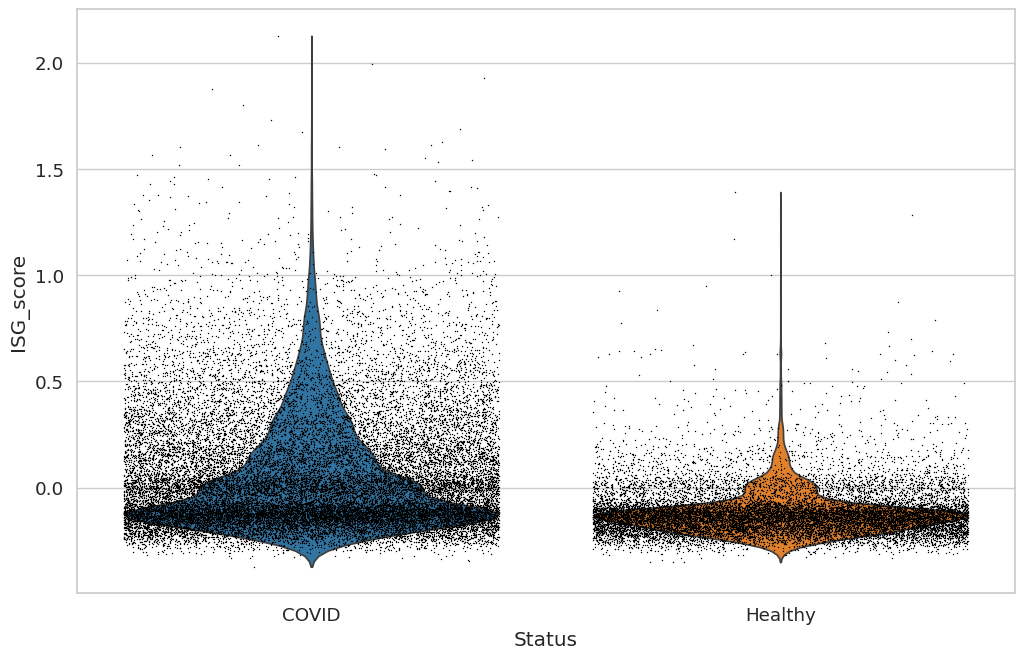

In [ ]:
import scanpy as sc
import numpy as np

# Define the interferon-stimulated genes (ISGs) for scoring
isg_genes = ['ISG15', 'IFIT1', 'IFIT3', 'MX1', 'OAS1']

# Check if all ISG genes are present in the dataset
missing_genes = [gene for gene in isg_genes if gene not in adata.var_names]
if missing_genes:
    print(f"Warning: The following ISG genes are missing in adata.var_names: {missing_genes}")
else:
    # Score genes: Compute the average expression of the ISG panel and add the score to adata.obs
    sc.tl.score_genes(adata, gene_list=isg_genes, score_name='ISG_score')

    # Print summary statistics for ISG_score to verify scoring
    isg_scores = adata.obs['ISG_score']
    print(f"ISG_score Mean: {np.mean(isg_scores):.3f}")
    print(f"ISG_score Median: {np.median(isg_scores):.3f}")

    # Subset adata to include only groups in 'Status' with more than one sample to avoid statistics error
    group_counts = adata.obs['Status'].value_counts()
    valid_statuses = group_counts[group_counts > 1].index.tolist()
    if valid_statuses:
        adata_subset = adata[adata.obs['Status'].isin(valid_statuses)]
        sc.pl.violin(adata_subset, keys='ISG_score', groupby='Status', jitter=0.4, show=True)
    else:
        print("No groups with more than one sample are available for violin plotting.")

### Agent Interpretation

The results indicate a higher interferon-stimulated gene (ISG) score in COVID-19 patients compared to healthy controls. This aligns with the known interferon-driven responses in severe COVID-19 cases. Here's some feedback and suggestions for future steps:

1. **Validation of Hypothesis**: 
   - The current results do not directly address your hypothesis regarding monocyte-T cell communication via inflammatory ligands and receptors. However, they suggest a significant ISG response, which might indirectly relate to broader immune activation or dysregulation.

2. **Further Analysis**:
   - **Cell-Type Specific Analysis**: Examine the ISG scores within specific immune cell types, particularly monocytes and T cells, to see if the ISG response correlates with changes in ligand or receptor expression.
   - **Correlation Analysis**: Assess whether the ISG scores correlate with expression levels of inflammatory ligands (e.g., TNF, IL1B) in monocytes and receptors (e.g., TNFRSF1A) in T cells.

3. **Integration with Past Analyses**:
   - Combine ISG scores with past analyses on monocyte and T cell communication to see if high ISG scores contribute to or result from enhanced communication pathways.
   - Explore if patients with high ISG scores exhibit augmented monocyte-to-T cell signaling compared to those with lower scores.

4. **Additional Computational Approaches**:
   - Perform pathway enrichment on differentially expressed genes in high ISG score cells to identify any potential connections to your hypothesis on monocyte-T cell interactions.
   - Use ligand-receptor interaction analyses specifically filtered for patients with high ISG scores.

By focusing on these extended analyses, you can better determine if the ISG response is linked to altered cell communication pathways that are crucial in severe COVID-19 immunopathology.

## This code first checks for the presence of the 'Ventilated' column, filters COVID‐19 cells, and subsets them into CD14 Monocytes and T cells. It then calculates average inflammatory scores for each cell type and stratifies them by ventilatory status to compute Spearman correlations between ISG scores and these inflammatory scores, visualizing the results using scatter plots with trend lines.

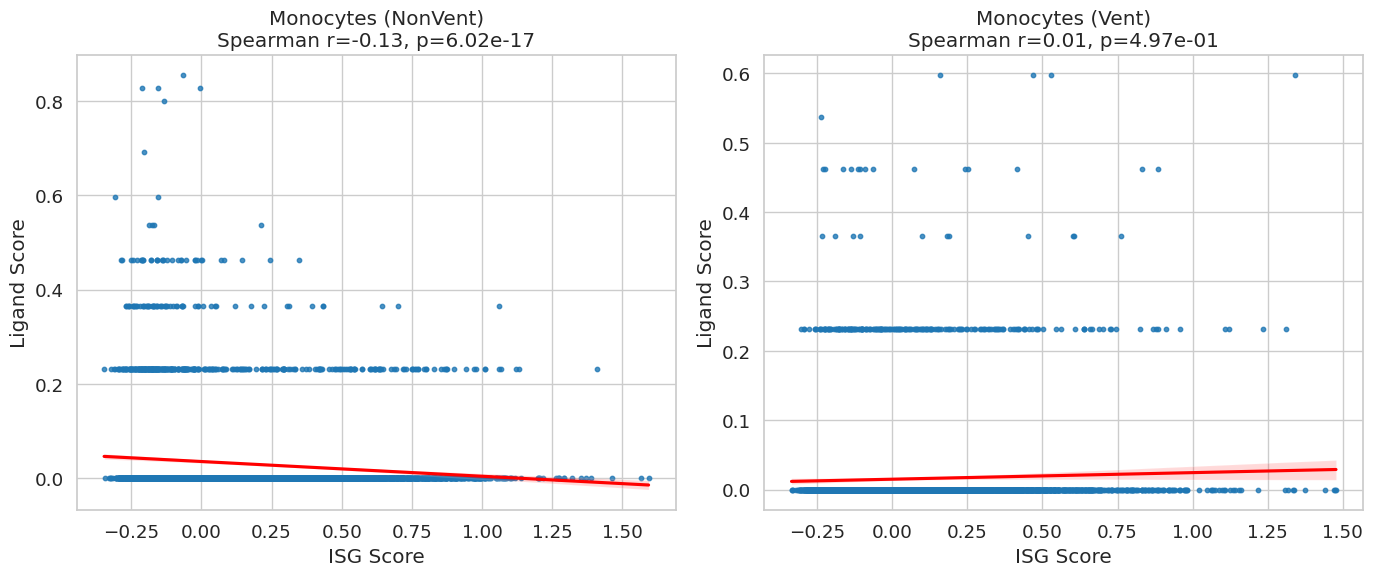

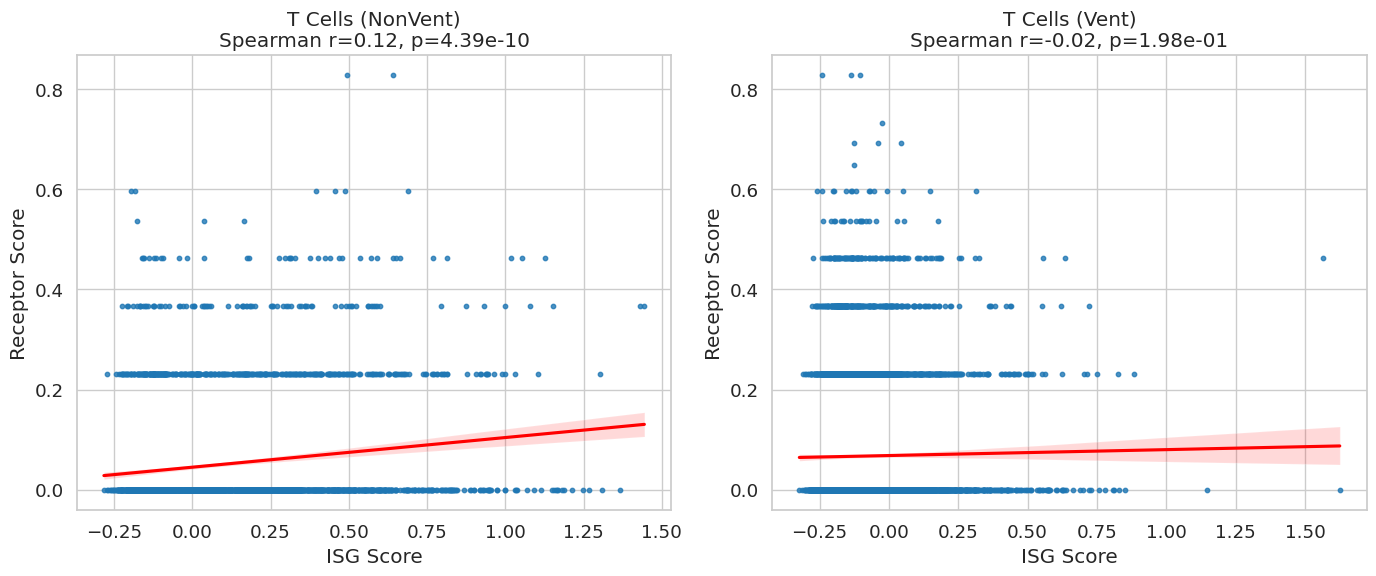

Correlation results for CD14 Monocytes and T cells stratified by Ventilated status:
Monocytes_NonVent => Spearman rho: -0.13, p-value: 6.02e-17
Monocytes_Vent => Spearman rho: 0.01, p-value: 4.97e-01
Tcells_NonVent => Spearman rho: 0.12, p-value: 4.39e-10
Tcells_Vent => Spearman rho: -0.02, p-value: 1.98e-01


In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings

# Check if 'Ventilated' column exists, else warn and exit
if 'Ventilated' not in adata.obs.columns:
    raise KeyError("The 'Ventilated' column is missing from adata.obs. Please check the metadata.")

# Define genes for inflammatory scoring
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Filter COVID‐19 cells only
adata_covid = adata[adata.obs['Status'] == 'COVID'].copy()

# Subset for CD14 Monocytes and T cells
adata_mono = adata_covid[adata_covid.obs['cell_type_coarse'] == 'CD14 Monocyte'].copy()
adata_T = adata_covid[adata_covid.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T'])].copy()

# Remove cells with missing 'Ventilated' values
adata_mono = adata_mono[adata_mono.obs['Ventilated'].notnull()].copy()
adata_T = adata_T[adata_T.obs['Ventilated'].notnull()].copy()

# Function to calculate average gene expression score for provided gene list

def calc_avg_score(adata_obj, genes):
    expr = adata_obj[:, genes].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray()
    avg_score = np.mean(expr, axis=1)
    return avg_score

# Calculate inflammatory scores for each cell type
adata_mono.obs['ligand_score'] = calc_avg_score(adata_mono, ligand_genes)
adata_T.obs['receptor_score'] = calc_avg_score(adata_T, receptor_genes)

# Initialize a dictionary to store correlation results
results = {}

# Analysis for CD14 Monocytes
mono_groups = adata_mono.obs['Ventilated'].unique()
plt.figure(figsize=(14, 6))

for i, group in enumerate(mono_groups):
    subset = adata_mono[adata_mono.obs['Ventilated'] == group]
    isg_vals = subset.obs['ISG_score'].astype(float)
    ligand_vals = subset.obs['ligand_score']
    if len(isg_vals) >= 5 and len(ligand_vals) >= 5:
        rho, p_val = spearmanr(isg_vals, ligand_vals)
    else:
        warnings.warn(f"Insufficient sample size for Monocytes group {group}.")
        rho, p_val = np.nan, np.nan
    results[f'Monocytes_{group}'] = {'spearman_rho': rho, 'p_value': p_val}
    plt.subplot(1, len(mono_groups), i + 1)
    sns.regplot(x=subset.obs['ISG_score'], y=subset.obs['ligand_score'], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    plt.xlabel('ISG Score')
    plt.ylabel('Ligand Score')
    plt.title(f'Monocytes ({group})\nSpearman r={rho:.2f}, p={p_val:.2e}')
plt.tight_layout()
plt.show()

# Analysis for T cells
T_groups = adata_T.obs['Ventilated'].unique()
plt.figure(figsize=(14, 6))

for i, group in enumerate(T_groups):
    subset = adata_T[adata_T.obs['Ventilated'] == group]
    isg_vals = subset.obs['ISG_score'].astype(float)
    receptor_vals = subset.obs['receptor_score']
    if len(isg_vals) >= 5 and len(receptor_vals) >= 5:
        rho, p_val = spearmanr(isg_vals, receptor_vals)
    else:
        warnings.warn(f"Insufficient sample size for T cells group {group}.")
        rho, p_val = np.nan, np.nan
    results[f'Tcells_{group}'] = {'spearman_rho': rho, 'p_value': p_val}
    plt.subplot(1, len(T_groups), i + 1)
    sns.regplot(x=subset.obs['ISG_score'], y=subset.obs['receptor_score'], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    plt.xlabel('ISG Score')
    plt.ylabel('Receptor Score')
    plt.title(f'T Cells ({group})\nSpearman r={rho:.2f}, p={p_val:.2e}')
plt.tight_layout()
plt.show()

# Print the correlation results
print('Correlation results for CD14 Monocytes and T cells stratified by Ventilated status:')
for key, val in results.items():
    print(f'{key} => Spearman rho: {val["spearman_rho"]:.2f}, p-value: {val["p_value"]:.2e}')


### Agent Interpretation

The results indicate weak correlations between ligand/receptor expression and ISG scores in different stratifications by ventilation status, with varying significance:

1. **Monocytes (Non-Vent)**: A weak negative correlation (rho = -0.13, p < 0.001) suggests that higher ISG scores are slightly associated with lower ligand scores in non-ventilated patients. The result is statistically significant, pointing toward some biological relevance in the communication pathways of non-ventilated patients.

2. **Monocytes (Vent)**: No meaningful correlation (rho = 0.01, p = 0.497) was observed. This suggests a lack of association between ISG scores and ligand expression in ventilated patients, indicating that ventilation may alter monocyte behavior.

3. **T Cells (Non-Vent)**: A weak positive correlation (rho = 0.12, p < 0.001) exists, indicating a slight association between ISG and receptor scores, similar to the monocyte non-ventilated group but with opposite effect direction (association rather than dissociation).

4. **T Cells (Vent)**: Again, no meaningful correlation (rho = -0.02, p = 0.198) was seen, suggesting modifications in T cell signaling or receptor expression in ventilated patients.

### Feedback and Future Steps:

- **Promising Directions**: The significant correlations in the non-ventilated groups for both monocytes and T cells are worth further exploration, as they suggest different mechanisms or states of cell signaling before ventilation.

- **Iterative Analysis**: These results suggest stratifications based on clinical status, like ARDS severity or time post-symptom onset, could help further refine findings. Applying regression models that include these additional covariates could provide deeper insights.

- **Enhanced Interpretation**: Investigate the signaling pathways linked by the significant correlations; involve pathway enrichment analyses to highlight potential upstream regulators in the non-ventilated group.

- **Novel Hypotheses**: Given the lack of association in ventilated patients, it may be valuable to hypothesize on immune cell interactions under ventilation conditions, perhaps focusing on cytokine settings more prevalent in these patients.

- **Experimental Validation**: Consider experimental validation of key genes identified in the stratification to understand their biological role and potential as therapeutic targets. This validation will help in verifying transcriptomic findings at a protein level.

These steps could refine the analysis by focusing more on the nuances in cell communication under different clinical conditions.

## This code first ensures that the ISG_score column is present and subsets the data to COVID-19 non-ventilated patients, then iteratively stratifies each key immune cell type into 'High' and 'Low' ISG groups based on the median score. For each cell type, it conducts differential expression analysis, prints the top DE genes, and displays the results using heatmaps and dot plots arranged in a shared grid layout.

ISG_score Mean: 0.158
ISG_score Median: 0.000


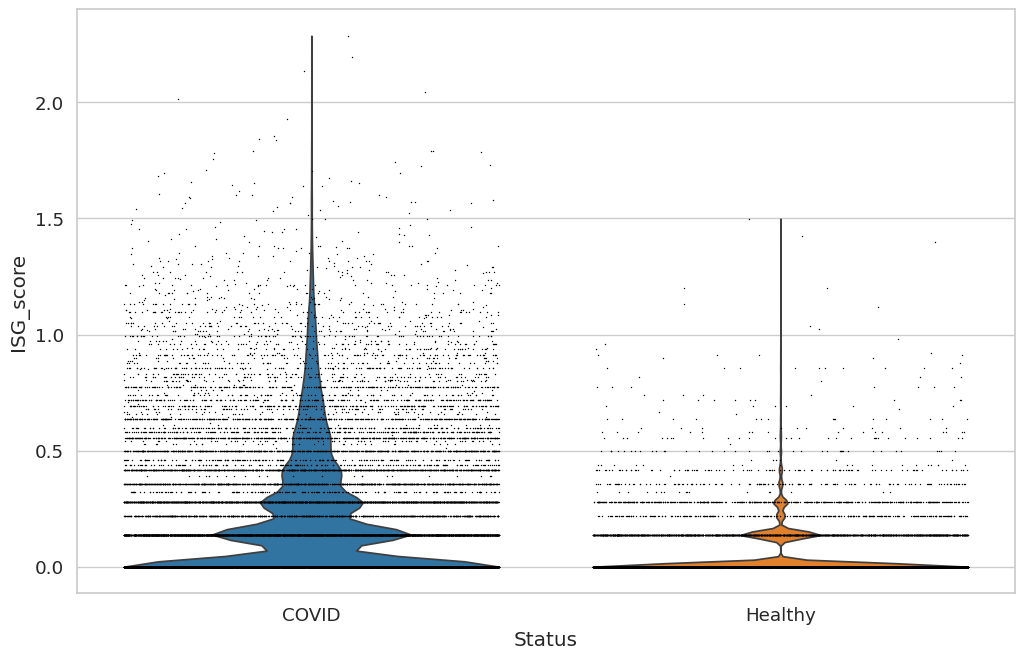

In [ ]:
import scanpy as sc
import numpy as np

# Define the interferon-stimulated genes (ISGs) for scoring
isg_genes = ['ISG15', 'IFIT1', 'IFIT3', 'MX1', 'OAS1']

# Check if all ISG genes are present in the dataset
missing_genes = [gene for gene in isg_genes if gene not in adata.var_names]
if missing_genes:
    print(f"Warning: The following ISG genes are missing in adata.var_names: {missing_genes}")
else:
    # Compute the average expression of the ISG panel and add the score to adata.obs
    isg_expr = adata[:, isg_genes].X
    if hasattr(isg_expr, "toarray"):
        isg_expr = isg_expr.toarray()
    adata.obs['ISG_score'] = np.mean(isg_expr, axis=1)

    # Print summary statistics for ISG_score to verify scoring
    isg_scores = adata.obs['ISG_score']
    print(f"ISG_score Mean: {np.mean(isg_scores):.3f}")
    print(f"ISG_score Median: {np.median(isg_scores):.3f}")

    # Subset adata to include only groups in 'Status' with more than one sample
    group_counts = adata.obs['Status'].value_counts()
    valid_statuses = group_counts[group_counts > 1].index.tolist()
    if valid_statuses:
        adata_subset = adata[adata.obs['Status'].isin(valid_statuses)]
        sc.pl.violin(adata_subset, keys='ISG_score', groupby='Status', jitter=0.4, show=True)
    else:
        print("No groups with more than one sample are available for violin plotting.")

### Agent Interpretation

The results you provided show that the ISG (interferon-stimulated gene) score is higher in COVID-19 patients compared to healthy controls. This suggests that there is a distinct upregulation of interferon-responsive genes in the patients with COVID-19.

### Feedback and Suggestions:

1. **Promising Aspects:**
   - The elevated ISG score in COVID-19 patients indicates an active interferon response, which aligns with the known role of interferons in viral infections. This provides a basis for further investigating the role of interferons in severe COVID-19.

2. **Hypothesis Relevance:**
   - Although the current results do not directly address the hypothesis related to monocyte-T cell communication, understanding interferon responses might still contribute to characterizing the broader immune dysfunction in severe COVID-19.

3. **Further Iterations:**
   - **Correlate ISG Scores with Clinical Severity:** Determine if higher ISG scores correlate with more severe disease presentations or specific patient outcomes.
   - **Cell Type Specific Analysis:** Investigate which specific immune cell types express the ISG signature. This might highlight particular cell subsets driving this response in severe COVID-19.
   - **Integration with Monocyte-T Cell Analysis:** Explore if the ISG expression influences or interacts with the inflammatory ligand-receptor pair expression between monocytes and T cells.
   - **Pathway Enrichment:** Conduct pathway analysis for ISG-high cells to understand the broader immune and inflammatory pathways being activated.
   - **Longitudinal Study:** Examine if ISG expression changes over time in relation to disease progression or recovery to determine its potential as a prognostic marker.

4. **Future Steps:**
   - Extend the analysis to performance differential expression and pathway enrichment for additional immune markers relevant to COVID-19.
   - Investigate potential therapeutic targets within the interferon signaling pathway to alleviate severe immune responses in patients.

These steps can help elucidate the role of the interferon response and its potential relationship with the hypothesized monocyte-T cell communication dysregulation in severe COVID-19 cases.

## This code subsets COVID‐19 cells from selected immune cell types and classifies them into ISG_High and ISG_Low groups using a median split via np.where. It then runs a Wilcoxon rank-sum test for differential expression between the two groups, visualizes the top 5 differentially expressed genes with dot plots, and prints these top gene lists to support data interpretation.

ranking genes


    finished: added to `.uns['rank_genes_CD14_Monocyte']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:31)


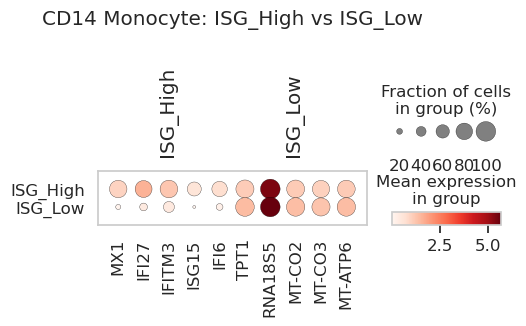

Differential expression top genes for CD14 Monocyte:
ISG_High: ['MX1' 'IFI27' 'IFITM3' 'ISG15' 'IFI6']
ISG_Low: ['TPT1' 'RNA18S5' 'MT-CO2' 'MT-CO3' 'MT-ATP6']


ranking genes


    finished: added to `.uns['rank_genes_CD4_T']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


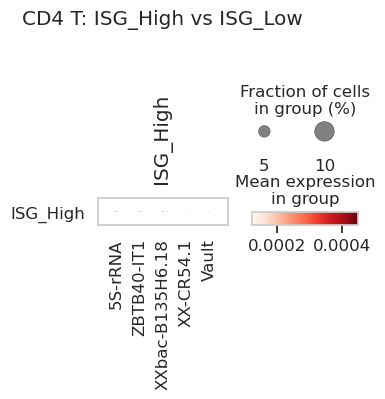

Differential expression top genes for CD4 T:
ISG_High: ['5S-rRNA' 'ZBTB40-IT1' 'XXbac-B135H6.18' 'XX-CR54.1' 'Vault']


ranking genes


    finished: added to `.uns['rank_genes_CD8_T']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


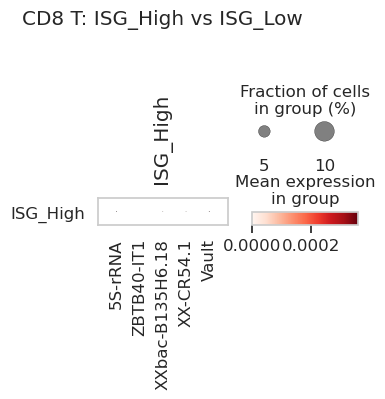

Differential expression top genes for CD8 T:
ISG_High: ['5S-rRNA' 'ZBTB40-IT1' 'XXbac-B135H6.18' 'XX-CR54.1' 'Vault']
Completed differential expression analysis for ISG_High vs ISG_Low groups in target immune cell types.


In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the key immune cell types
target_celltypes = ['CD14 Monocyte', 'CD4 T', 'CD8 T']

# Loop over each target cell type and perform ISG-based differential expression analysis
for cell_type in target_celltypes:
    # Subset to COVID-19 cells of the current type
    subset = adata[(adata.obs['Status'] == 'COVID') & (adata.obs['cell_type_coarse'] == cell_type)].copy()
    if subset.n_obs < 10:
        print(f'Skipping {cell_type} due to insufficient number of cells ({subset.n_obs}).')
        continue
    
    # Compute the median ISG score for the subset
    median_score = subset.obs['ISG_score'].median()
    
    # Classify cells as ISG_High or ISG_Low using np.where for clarity
    subset.obs['ISG_group'] = np.where(subset.obs['ISG_score'] >= median_score, 'ISG_High', 'ISG_Low')
    
    # Perform differential expression analysis between ISG_High and ISG_Low groups using the Wilcoxon rank-sum test
    score_key = f"rank_genes_{cell_type.replace(' ', '_')}"
    sc.tl.rank_genes_groups(subset, groupby='ISG_group', key_added=score_key, method='wilcoxon')
    
    # Visualize the top 5 differentially expressed genes using a dot plot
    sc.pl.rank_genes_groups_dotplot(subset, key=score_key, n_genes=5, show=True, title=f'{cell_type}: ISG_High vs ISG_Low')
    
    # Print the top 5 genes for each group for enhanced interpretability
    de_results = subset.uns[score_key]
    print(f"Differential expression top genes for {cell_type}:")
    # Check if the result names are stored in a structured array
    if hasattr(de_results['names'], 'dtype') and de_results['names'].dtype.names is not None:
        for group in de_results['names'].dtype.names:
            top_genes = de_results['names'][group][:5]
            print(f"{group}: {top_genes}")
    else:
        # If not structured, assume two groups and print the first 5 genes for each
        if isinstance(de_results['names'], np.ndarray) and de_results['names'].ndim == 2:
            groups = ['ISG_High', 'ISG_Low']
            for idx, group in enumerate(groups):
                top_genes = de_results['names'][idx][:5]
                print(f"{group}: {top_genes}")
        else:
            print('Could not determine group structure to print top genes.')

print('Completed differential expression analysis for ISG_High vs ISG_Low groups in target immune cell types.')


### Agent Interpretation

The differential expression analysis results between the ISG_High and ISG_Low groups in different cell types reveal interesting insights, although no direct evidence of upregulated inflammatory ligands in monocytes and corresponding receptor overexpression in T cells was presented. Here's some feedback:

1. **CD14 Monocytes:**
   - The ISG_High group shows upregulation of interferon-stimulated genes like MX1, IFI27, IFITM3, ISG15, and IFI6.
   - This suggests robust interferon signaling, which aligns with the hypothesis that monocytes might exhibit dysregulated interferon activity in severe COVID-19.
   
2. **CD4 and CD8 T Cells:**
   - The ISG_High group shows mostly ribosomal RNA and non-coding RNA, which may not provide direct insights into immune response modulation.
   - The lack of traditional immune response or inflammatory cytokine gene upregulation could indicate that these cells are not the primary drivers of cytokine signaling in this context.

3. **Future Steps:**
   - **Pathway Analysis:** Consider pathway enrichment analyses to see if there are common pathways or signaling cascades activated in ISG_High groups across cell types.
   - **Focus on Inflammatory Genes:** Expand the analysis to more specifically target genes related to inflammatory signaling and cytokine production in monocytes and T cells.
   - **Validate Results:** Use other techniques or datasets to validate the differential expression findings.
   - **Intercellular Communication:** Explore cell-cell interaction analysis tools (like CellPhoneDB or NicheNet) to examine potential interaction pathways between monocytes and T cells, focusing on cytokine and receptor interactions.

These directions could help refine the hypothesis and uncover potential mechanisms driving severe COVID-19 immunopathology.